In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from typing import Final
from matplotlib import rcParams

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (28, 18)
rcParams['figure.dpi'] = 50
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

CALIBRATION: Final[float] = 1.362 # [px/µm]

def binarize_image(image, threshold, show=False):

    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    # Show the original and binarized images
    if show:
        cv2.imshow('Original Image', image)
        cv2.imshow('Binarized Image', binary_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return binary_image

def get_canny_edges(binary_image, show = False):
    edges = cv2.Canny(binary_image, 100, 200)  # Adjust the threshold values as needed
    if show:
        cv2.imshow('Detected edges', edges)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return edges

def rotate_image(image, angle, show = False):    
    # Get image dimensions
    height, width = image.shape[:2]
    
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    
    # Apply rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    
    if show:
        # Show the original and rotated images
        cv2.imshow('Original Image', image)
        cv2.imshow('Rotated Image', rotated_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return rotated_image

def cortar(image, limites):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    first_cut = image[:max_y, :max_x]
    second_cut = first_cut[min_y:, min_x:]

    return second_cut

In [9]:
image_path = 'Capilares/C4-diam-5x-1Light.jpg'  # Replace 'example_image.jpg' with the path to your image
threshold_value = 200  # Threshold value (0-255)
rotation_angle = -3.30  # Rotation angle in degrees
calibration = 1.362 # [px/µm]
#fimg = get_canny_edges(rotate_image(binarize_image(image_path, threshold_value), rotation_angle))
gray_img = rotate_image(
    image=cv2.cvtColor(
        cv2.imread(image_path), 
        cv2.COLOR_BGR2GRAY
    ),
    angle=rotation_angle
)

### Maquina de hacer chorizos

In [ ]:
vertical_resolution = 2160 # la resolución vertical de nuestras imagenes - 500
rot_arr = -1*np.array([3.85,3.30,3.50,4.60,4.40]) # C1,...,C5
calibration = 1.362 # px/µm
threshold_value = 127

y_cut = 1000
yd_array = np.arange(y_cut,vertical_resolution-y_cut) #agarro un corte vertical
diam_array = np.empty(yd_array.size, dtype="object") #mi array de diametros va a tener a lo sumo yd_array.size valores

for n,alpha in enumerate(rot_arr):
    img_path = 'Capilares/C'+str(n+1)+'-diam-5x-1Light.jpg'
    #roto la imagen en escala de grises
    gray_img = rotate_image(
        image = cv2.cvtColor(
            cv2.imread(img_path), 
            cv2.COLOR_BGR2GRAY
        ),
        angle = alpha
    )
    
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    #por cada índice de mi corte vertical
    for i in yd_array:
        y = gray_img[i]
        x = np.arange(y.size)/calibration
        
        y_left = y[:y.size//2] #tomamos hasta la mitad no inclusive
        y_right = y[y.size//2:] #tomamos de la mitad
        x_left_peak = find_peaks(y_left, height=120, width=2)[0]
        x_right_peak = find_peaks(y_right, height=120, width=2)[0]
        
        if x_left_peak.size!=0 and x_right_peak.size!=0:
            xpeak_array = np.array([x_left_peak[0],
                                    x_right_peak[-1] + y.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
            ypeak_array = np.array([y[xpeak_array[0]],
                                    y[xpeak_array[1]]])
            diam_array[i - y_cut] = (xpeak_array[1] - xpeak_array[0])/calibration #le restamos y_cut al índice para q empiece en 0

        ax1.plot(x,y,color='k')
        ax1.plot(xpeak_array/calibration,ypeak_array,'x',color='r')
    
    print("Radio de C"+str(n+1))
    print(np.average(diam_array)/2,np.std(diam_array)/2)
    
    ax2.plot(yd_array/calibration, diam_array, 'o', color='tab:blue')
    
    ax2.set_ylabel('diametro [µm]')
    ax2.set_xlabel('distancia-y [µm]')            
    ax1.set_xlabel('distancia-x [µm]')
    ax1.set_ylabel('grayscale (0-255)')
    fig.suptitle('C'+str(n+1))
    fig.tight_layout()

## Filamentos

3700 1548
Diámetro de filamento
1018.4052863436123 3.15962882401686
Radio de filamento
509.20264317180613 1.57981441200843


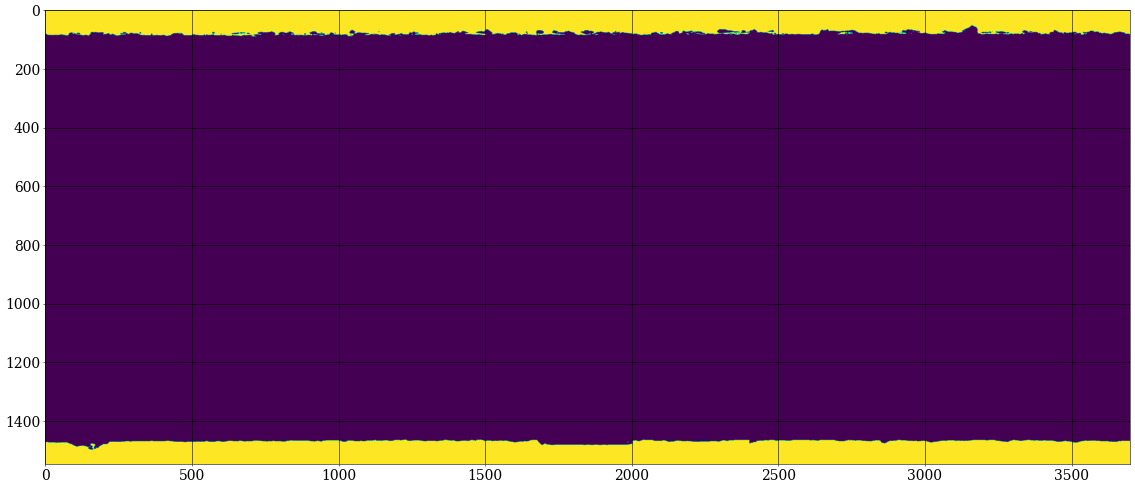

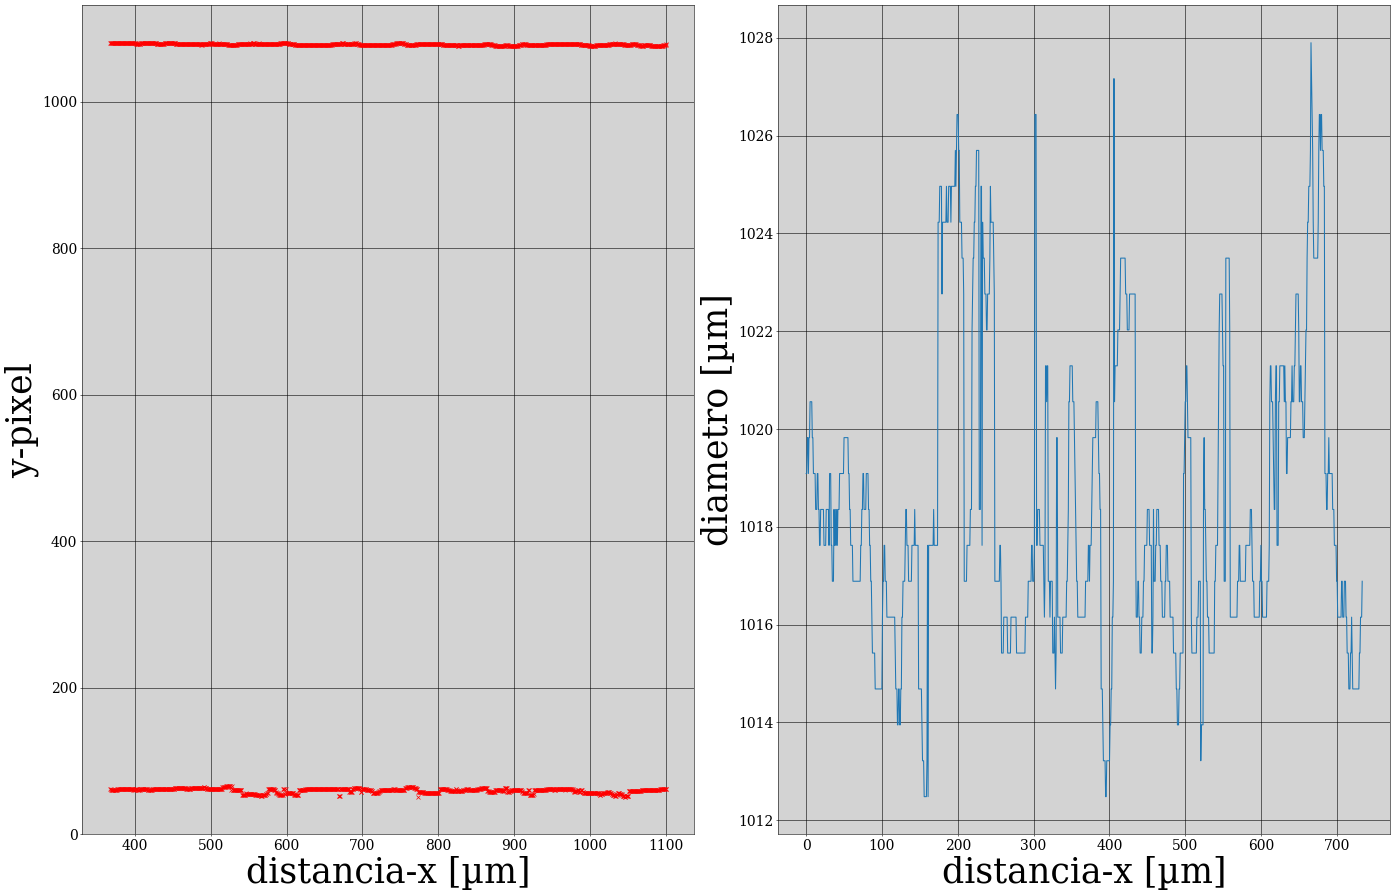

In [4]:
img_path = 'ECO20-Fotos/E0020_006_R.jpg'
gray_img = binarize_image(
    image=cv2.cvtColor(
        cv2.imread(img_path), 
        cv2.COLOR_BGR2GRAY),
    threshold=80
)
plt.imshow(gray_img)
xsize = gray_img[0,:].size
ysize = gray_img[:,0].size

print(xsize,ysize)

diam_array = np.array([])

fig, (ax1,ax2) = plt.subplots(1,2)

#por cada índice de mi corte vertical
for i in np.arange(500,1500):
    vslice = gray_img[:,i]
    x = np.arange(vslice.size)/CALIBRATION
    
    y_left = vslice[:vslice.size//2] #tomamos hasta la mitad no inclusive
    y_right = vslice[vslice.size//2:] #tomamos de la mitad
    x_left_peak = np.argwhere(y_left==255)
    x_right_peak = np.argwhere(y_right==255)
    
    if x_left_peak.size!=0 and x_right_peak.size!=0:
        xl = x_left_peak[-1]
        xr = x_right_peak[0]
        xpeak_array = np.array([xl, xr + vslice.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
        ypeak_array = np.array((i,i))
        diam_array = np.append(diam_array,(xpeak_array[1] - xpeak_array[0])/CALIBRATION)
        ax1.plot(ypeak_array/CALIBRATION,xpeak_array/CALIBRATION,'x',color='r')

print("Diámetro de filamento")
print(np.average(diam_array),np.std(diam_array))

print("Radio de filamento")
print(np.average(diam_array)/2,np.std(diam_array)/2)

ax2.plot((np.arange(0,diam_array.size))/CALIBRATION, diam_array, color='tab:blue')

ax2.set_ylabel('diametro [µm]')
ax2.set_xlabel('distancia-x [µm]')            
ax1.set_xlabel('distancia-x [µm]')
ax1.set_ylabel('y-pixel')
fig.tight_layout()

## Cabecillas

### Encontrando los límites correctos para la foto de la cabecilla

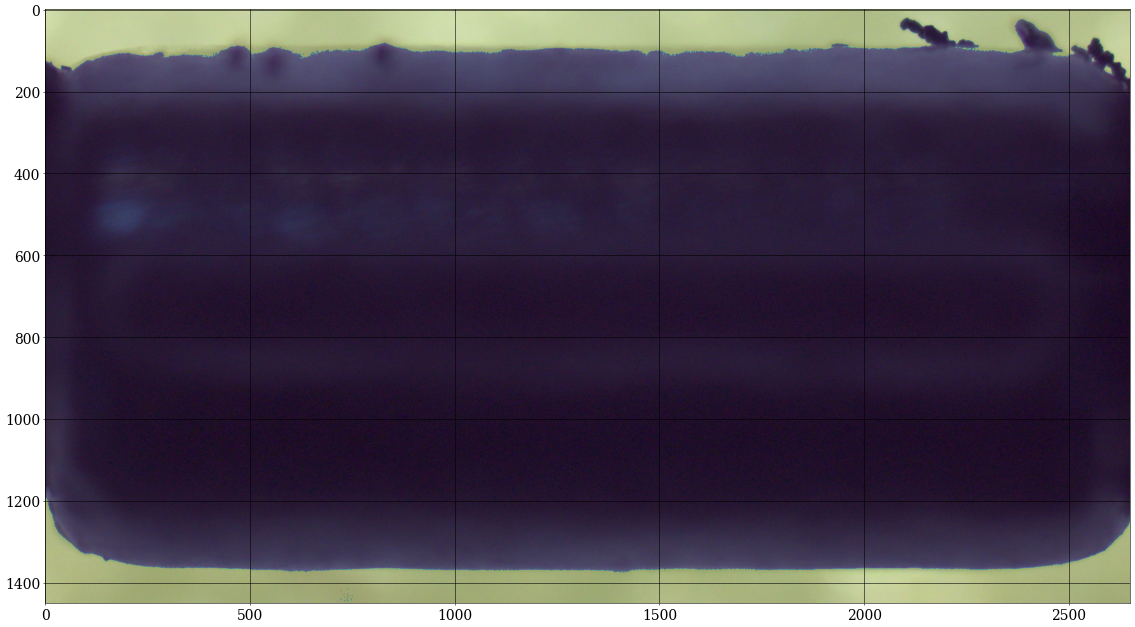

In [109]:
img_path = './cabecilla.png'

im_cut = cortar(
    image = rotate_image(
        image = cv2.imread(img_path),
        angle = 10
    ),
    limites = [550,3200,400,1850]
)
gray_image = cv2.cvtColor(im_cut, cv2.COLOR_BGR2GRAY)
im = binarize_image(gray_image,132)
fig, ax = plt.subplots()
ax.imshow(im)
ax.imshow(im_cut, alpha=0.7)

### Obteniendo diámetro de cabecilla

2650 1450
Diametro de cabecilla
923.8641841908403 24.95501547199535
Radio de cabecilla
461.93209209542016 12.477507735997674


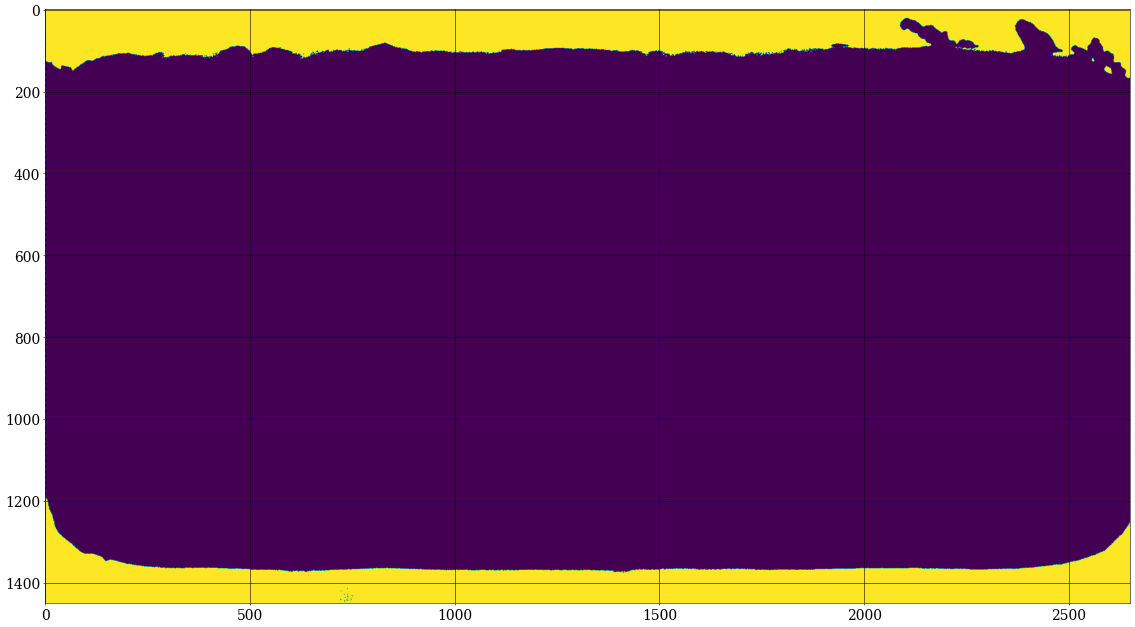

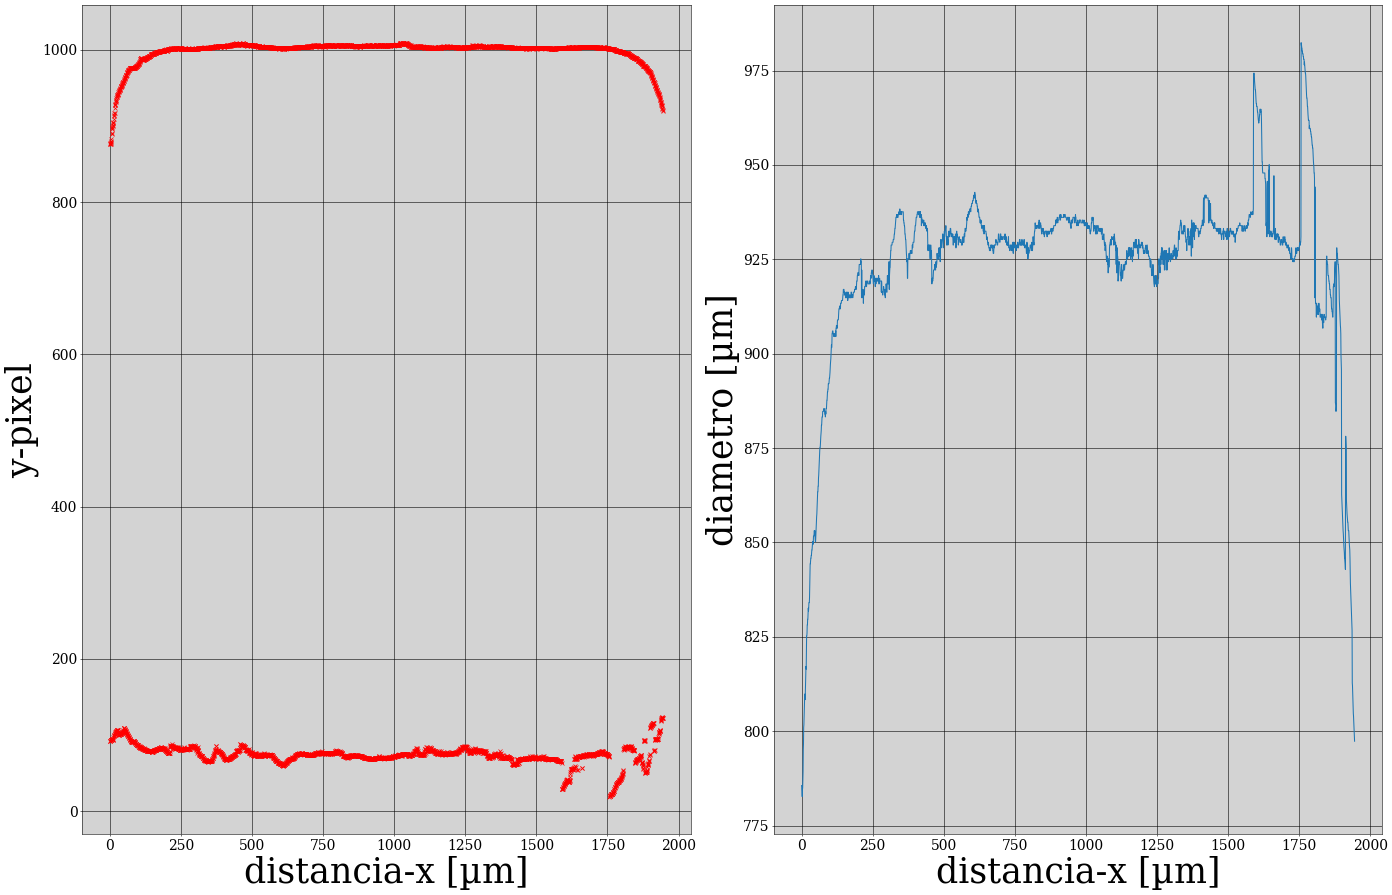

In [108]:
xsize = im[0,:].size
ysize = im[:,0].size
min_vslice = 0
max_vslice = xsize

print(xsize,ysize)


fig,ax = plt.subplots()
ax.axvline(min_vslice, color='r', ls='--')
ax.axvline(max_vslice, color='r', ls='--')
ax.imshow(im)

diam_array = np.array([])

fig, (ax1,ax2) = plt.subplots(1,2)

#por cada índice de mi corte vertical
for i, vslice in enumerate( im[:, min_vslice:max_vslice].T ):
    
    x = np.arange(vslice.size)/CALIBRATION

    y_left = vslice[:vslice.size//2] #tomamos hasta la mitad no inclusive
    y_right = vslice[vslice.size//2:] #tomamos de la mitad
    x_left_peak = np.argwhere(y_left==255)
    x_right_peak = np.argwhere(y_right==255)
    
    if x_left_peak.size!=0 and x_right_peak.size!=0:
        xl = x_left_peak[-1]

        xr = x_right_peak[0]
        xpeak_array = np.array([xl, xr + vslice.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
        ypeak_array = np.array((i,i))
        diam_array = np.append(diam_array,(xpeak_array[1] - xpeak_array[0])/CALIBRATION)
        ax1.plot(ypeak_array/CALIBRATION,xpeak_array/CALIBRATION,'x',color='r')

print("Diametro de cabecilla")
print(np.average(diam_array),np.std(diam_array))
print("Radio de cabecilla")
print(np.average(diam_array)/2,np.std(diam_array)/2)

ax2.plot((np.arange(0,diam_array.size))/CALIBRATION, diam_array, color='tab:blue')

ax2.set_ylabel('diametro [µm]')
ax2.set_xlabel('distancia-x [µm]')
ax1.set_xlabel('distancia-x [µm]')
ax1.set_ylabel('y-pixel')
fig.tight_layout()